---

# **Resources**

---

1. **YOLOv8 Model :**
https://colab.research.google.com/drive/1dLQbgB36-feLfeXGVaqYtxWJInOzluzA?usp=sharing

2. **Keras Model (Current Notebook) :**
https://colab.research.google.com/drive/1iQrTvWXY52ANWjOoOOFHyQTlrQfU2VvV?usp=sharing

---

# **Others (If Needed)**

---

In [ ]:
# Install TensorFlowJS Module (To save and convert the model in .json format)
!pip install tensorflowjs

In [ ]:
# TensorFlow Lite metadata supporting tools
!pip install tflite_support

In [ ]:
# Unzip "fitness_CNN_binary_1.zip" - Exercise Balls & Kettlebell
!unzip 'fitness_CNN_binary_1.zip' -d 'fitness_1'

In [ ]:
# Unzip "fitness_CNN_binary_2.zip" - Benchpress & Dumbells
!unzip 'fitness_CNN_binary_2.zip' -d 'fitness_2'

In [ ]:
# Unzip "fitness_CNN_binary_3.zip" - Lesser Images of Benchpress & Dumbells v1
!unzip 'fitness_CNN_binary_3.zip' -d 'fitness_3'

In [ ]:
# Unzip "fitness_CNN_binary_4.zip" - Lesser Images of Benchpress & Dumbells v2
!unzip 'fitness_CNN_binary_4.zip' -d 'fitness_4'

In [ ]:
# Unzip "fitness_CNN_binary_5.zip" - Lesser Images of Benchpress & Dumbells v3
!unzip 'fitness_CNN_binary_5.zip' -d 'fitness_5'

In [ ]:
# Delete Specific Folder
shutil.rmtree('saved_model')

---

# **Experiment #1**

---

# **Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import shutil
import time
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torchvision import transforms
from PIL import Image

# **#1 - Exercise Ball & Kettlebell**

**Total "Exercise Balls" images for Training :**

*   122

**Total "Kettlebell" images for Training :**

*   122

**Total "Exercise Balls" images for Validation :**

*   48

**Total "Kettlebell" images for Validation :**

*   48

## **Data Preprocessing**

### **Directory Setup**

In [ ]:
# Base Directory
base_dir = 'fitness_1/fitness_CNN_binary_1'

# Train & Validation Directory
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Train Exercise Balls & Kettlebell Directory
train_exerbal_dir = os.path.join(train_dir, 'Exercise Balls')
train_kettle_dir = os.path.join(train_dir, 'Kettlebell')

# Validation Exercise Balls & Kettlebell Directory
validation_exerbal_dir = os.path.join(validation_dir, 'Exercise Balls')
validation_kettle_dir = os.path.join(validation_dir, 'Kettlebell')

In [ ]:
# Show some images labels
train_exerbal_fnames = os.listdir(train_exerbal_dir)
train_kettle_fnames = os.listdir(train_kettle_dir)
print(train_exerbal_fnames[:10])
print(train_kettle_fnames[:10])

['yoga-accessories-anti-burst-yoga-ball-55cm.jpg', '20211226_130621_jpg.rf.b87a79e07303b788a8070a8b2a95501f.jpg', '20211224_190032_jpg.rf.c36f86acf2846b9df4931d31760f49ee - Copy.jpg', '20211226_130630_jpg.rf.94cbb519b5998b2343e56408786ff6f0 - Copy.jpg', 'REF_ExerciseBall_85cm.jpg', '20211226_130702_jpg.rf.da77ac694554ef801558238ea8df9436 - Copy.jpg', '20211224_185933_jpg.rf.08690b6c03d99d57aa1397f08067ce4c.jpg', '20211226_130659_jpg.rf.4d4a321e5cf2aff193c0c2a560fd4ae2 - Copy.jpg', '20211226_130658_jpg.rf.3d5f8a32266542632f85959b1c08fd64 - Copy.jpg', '20211224_185952_jpg.rf.c7bda64f65493a5e9be4b85455a6b2d1.jpg']
['kettlebellkings-powdercoatkettlebell-kg.jpg', '20211224_185453_jpg.rf.84cbbf29ff9dd25fb1c778cd0fb9f44b - Copy.jpg', 'download (6).jpg', '20211224_185408_jpg.rf.93e0f66e10202ef6ad93ccadc96efd60.jpg', '20211224_185459_jpg.rf.d410ea5e4854b867704f3f557f687ce1 - Copy.jpg', '20211224_185413_jpg.rf.4c17bab17598ef69d2873632d806d5c7 - Copy (2) - Copy.jpg', '20211224_185408_jpg.rf.93e0f

In [ ]:
# Total Images
print('total training Exercise Balls images :', len(os.listdir(train_exerbal_dir)))
print('total training Kettlebell images :', len(os.listdir(train_kettle_dir)))
print('total validation Exercise Balls images :', len(os.listdir(validation_exerbal_dir)))
print('total validation Kettlebell images :', len(os.listdir(validation_kettle_dir)))

total training Exercise Balls images : 122
total training Kettlebell images : 122
total validation Exercise Balls images : 48
total validation Kettlebell images : 48


### **Prepare Image - No Converting to TensorImage**

In [ ]:
# # All images will be rescaled by 1./255.
# train_datagen = ImageDataGenerator( rescale = 1.0/255. )
# test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# # --------------------
# # Flow training images in batches of 20 using train_datagen generator
# # --------------------
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     batch_size=20,
#                                                     class_mode='binary',
#                                                     target_size=(250, 250))
# # --------------------
# # Flow validation images in batches of 20 using test_datagen generator
# # --------------------
# validation_generator =  test_datagen.flow_from_directory(validation_dir,
#                                                          batch_size=20,
#                                                          class_mode  = 'binary',
#                                                          target_size = (250, 250))

### **Prepare Image - Convert to TensorImage**

In [ ]:
def load_images_to_tensors(exerbal_dir, kettle_dir, target_size=(250, 250)):
    tensor_images = []
    labels = []  # 0 for Exercise Balls, 1 for Kettlebells

    # Function to load images from a directory and assign a label
    def load_images_from_dir(directory, label):
        for file_name in os.listdir(directory):
            file_path = os.path.join(directory, file_name)
            # Load the image
            img = image.load_img(file_path, target_size=target_size)
            # Convert the image to a numpy array and rescale
            img_array = image.img_to_array(img) / 255.0
            # Convert to tensor
            tensor_img = tf.convert_to_tensor(img_array, dtype=tf.float32)

            tensor_images.append(tensor_img)
            labels.append(label)

    # Load images from Exercise Balls directory
    load_images_from_dir(exerbal_dir, 0)

    # Load images from Kettlebells directory
    load_images_from_dir(kettle_dir, 1)

    return np.array(tensor_images), np.array(labels)

In [ ]:
batch_size = 20

In [ ]:
# Load images as tensors
train_tensors, train_labels = load_images_to_tensors(train_exerbal_dir, train_kettle_dir)

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, train_labels))

# Batch and shuffle the dataset
train_dataset = train_dataset.shuffle(len(train_tensors)).batch(batch_size)
# .repeat()

In [ ]:
# Load validation images as tensors
validation_tensors, validation_labels = load_images_to_tensors(validation_exerbal_dir, validation_kettle_dir)

# Create TensorFlow Dataset for validation
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_tensors, validation_labels))

# Batch the dataset (adjust batch size if needed)
validation_dataset = validation_dataset.batch(batch_size)
# .repeat()

### **Show Images**

In [ ]:
# Output: Images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0

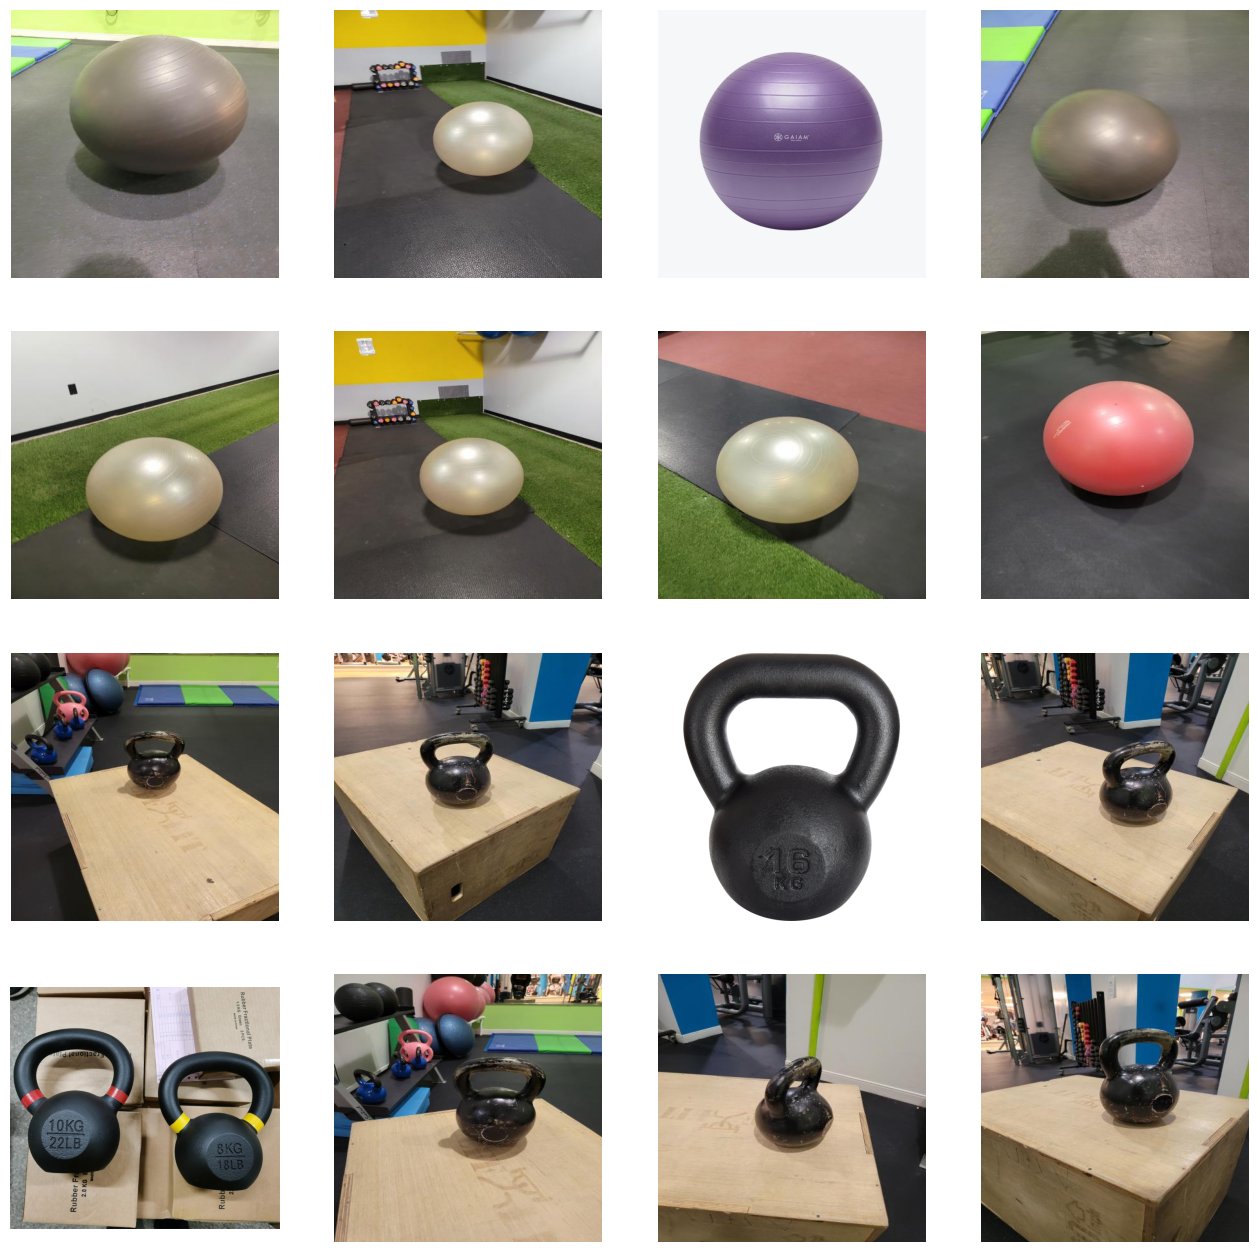

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_exerbal_pix = [os.path.join(train_exerbal_dir, fname)
                for fname in train_exerbal_fnames[ pic_index-8:pic_index]
               ]

next_kettle_pix = [os.path.join(train_kettle_dir, fname)
                for fname in train_kettle_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_exerbal_pix+next_kettle_pix):
    # Subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## **Create Model**

In [ ]:
# Create the Model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 250x250 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 638, 638, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 319, 319, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 317, 317, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 158, 158, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 156, 156, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 78, 78, 64)        0

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.85 and logs.get('val_acc')>0.85 and logs.get('loss')<0.3 and logs.get('val_loss')<0.3):
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## **Model Training**

In [ ]:
train_steps = float((len(os.listdir(train_exerbal_dir)) + len(os.listdir(train_kettle_dir))) / batch_size)
val_steps = float((len(os.listdir(validation_exerbal_dir)) + len(os.listdir(validation_kettle_dir))) / batch_size)

print('Steps per Epochs :', train_steps)
print('Validation Steps :', val_steps)

Steps per Epochs : 12.2
Validation Steps : 4.8


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=13,
    validation_steps=5,
    epochs=10,
    callbacks=[callbacks],
    verbose=1
)

Epoch 1/10
13/13 [==============================] - 18s 414ms/step - loss: 5.2960 - acc: 0.5779 - val_loss: 0.5450 - val_acc: 0.7292
Epoch 2/10
13/13 [==============================] - 3s 194ms/step - loss: 0.5217 - acc: 0.7746 - val_loss: 0.4597 - val_acc: 0.7396
Epoch 3/10
13/13 [==============================] - 3s 214ms/step - loss: 0.4451 - acc: 0.8443 - val_loss: 0.1200 - val_acc: 0.9479
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 0.1404 - acc: 0.9467
Reached 99.8% accuracy so cancelling training!
13/13 [==============================] - 3s 225ms/step - loss: 0.1404 - acc: 0.9467 - val_loss: 0.0365 - val_acc: 1.0000


## **Model Evaluation**

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

print(f"Training Accuracy: {pd.to_numeric(acc)[-1]*100} %")
print(f"Validation Accuracy: {pd.to_numeric(val_acc)[-1]*100} %")
print(f"Training Loss: {pd.to_numeric(loss)[-1]}")
print(f"Validation Loss: {pd.to_numeric(val_loss)[-1]}")

Training Accuracy: 96.72130942344666 %
Validation Accuracy: 100.0 %
Training Loss: 0.16275501251220703
Validation Loss: 0.0368654765188694


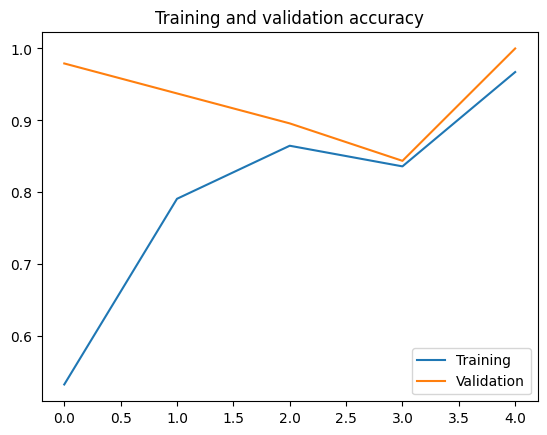

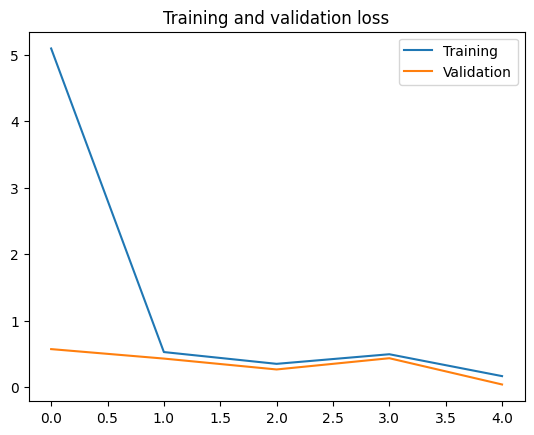

In [ ]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.title('Training and validation loss')
plt.show()

# **#2 - Benchpress & Dumbells**

**Total "Benchpress" images for Training :**

*   521

**Total "Dumbells" images for Training :**

*   2003

**Total "Benchpress" images for Validation :**

*   130

**Total "Dumbells" images for Validation :**

*   500

## **Data Preprocessing**

### **Directory Setup**

In [ ]:
# Base Directory
base_dir = 'fitness_2/fitness_CNN_binary_2'

# Train & Validation Directory
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Train Benchpress & Dumbells Directory
train_bench_dir = os.path.join(train_dir, 'Benchpress')
train_dumbel_dir = os.path.join(train_dir, 'Dumbells')

# Validation Benchpress & Dumbells Directory
validation_bench_dir = os.path.join(validation_dir, 'Benchpress')
validation_dumbel_dir = os.path.join(validation_dir, 'Dumbells')

In [ ]:
# Show some images labels
train_bench_fnames = os.listdir(train_bench_dir)
train_dumbel_fnames = os.listdir(train_dumbel_dir)
print(train_bench_fnames[:10])
print(train_dumbel_fnames[:10])

['00000452.jpg', '00000356.jpg', '00000238.jpg', '00000510.jpg', '00000089.jpg', '00000381.jpg', '00000071.jpg', '00000231.jpg', '00000132.jpg', '00000373.jpg']
['HMC6RPWPNG4C.jpg', '00000452.jpg', '00000356.jpg', '4CCT78CLAD43.jpg', '1YVB151P6IJC.jpg', 'JCTPOUINZ0B4.jpg', '1SJA270FZ0Z6.jpg', '3HQVSSQBT6C9.jpg', '1IWQ8BGLOA8T.jpg', '0KXANHMOZUC8.jpg']


In [ ]:
# Total Images
print('total training Benchpress images :', len(os.listdir(train_bench_dir)))
print('total training Dumbells images :', len(os.listdir(train_dumbel_dir)))
print('total validation Benchpress images :', len(os.listdir(validation_bench_dir)))
print('total validation Dumbells images :', len(os.listdir(validation_dumbel_dir)))

total training Benchpress images : 521
total training Dumbells images : 2003
total validation Benchpress images : 130
total validation Dumbells images : 500


### **Prepare Image - No Converting to TensorImage**

In [ ]:
# # All images will be rescaled by 1./255.
# train_datagen = ImageDataGenerator( rescale = 1.0/255. )
# test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# # --------------------
# # Flow training images in batches of 20 using train_datagen generator
# # --------------------
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     batch_size=20,
#                                                     class_mode='binary',
#                                                     target_size=(250, 250))
# # --------------------
# # Flow validation images in batches of 20 using test_datagen generator
# # --------------------
# validation_generator =  test_datagen.flow_from_directory(validation_dir,
#                                                          batch_size=20,
#                                                          class_mode  = 'binary',
#                                                          target_size = (250, 250))

### **Prepare Image - Convert to TensorImage**

In [ ]:
def load_images_to_tensors(bench_dir, dumbel_dir, target_size=(250, 250)):
    tensor_images = []
    labels = []  # 0 for Exercise Balls, 1 for Kettlebells

    # Function to load images from a directory and assign a label
    def load_images_from_dir(directory, label):
        for file_name in os.listdir(directory):
            file_path = os.path.join(directory, file_name)
            # Load the image
            img = image.load_img(file_path, target_size=target_size)
            # Convert the image to a numpy array and rescale
            img_array = image.img_to_array(img) / 255.0
            # Convert to tensor
            tensor_img = tf.convert_to_tensor(img_array, dtype=tf.float32)

            tensor_images.append(tensor_img)
            labels.append(label)

    # Load images from Exercise Balls directory
    load_images_from_dir(bench_dir, 0)

    # Load images from Kettlebells directory
    load_images_from_dir(dumbel_dir, 1)

    return np.array(tensor_images), np.array(labels)

In [ ]:
batch_size = 20

In [ ]:
# Load images as tensors
train_tensors, train_labels = load_images_to_tensors(train_bench_dir, train_dumbel_dir)

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, train_labels))

# Batch and shuffle the dataset
train_dataset = train_dataset.shuffle(len(train_tensors)).batch(batch_size)
# .repeat()

In [ ]:
# Load validation images as tensors
validation_tensors, validation_labels = load_images_to_tensors(validation_bench_dir, validation_dumbel_dir)

# Create TensorFlow Dataset for validation
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_tensors, validation_labels))

# Batch the dataset (adjust batch size if needed)
validation_dataset = validation_dataset.batch(batch_size)
# .repeat()

### **Show Images**

In [ ]:
# # Output: Images in a 4x4 configuration
# nrows = 4
# ncols = 4

# pic_index = 0

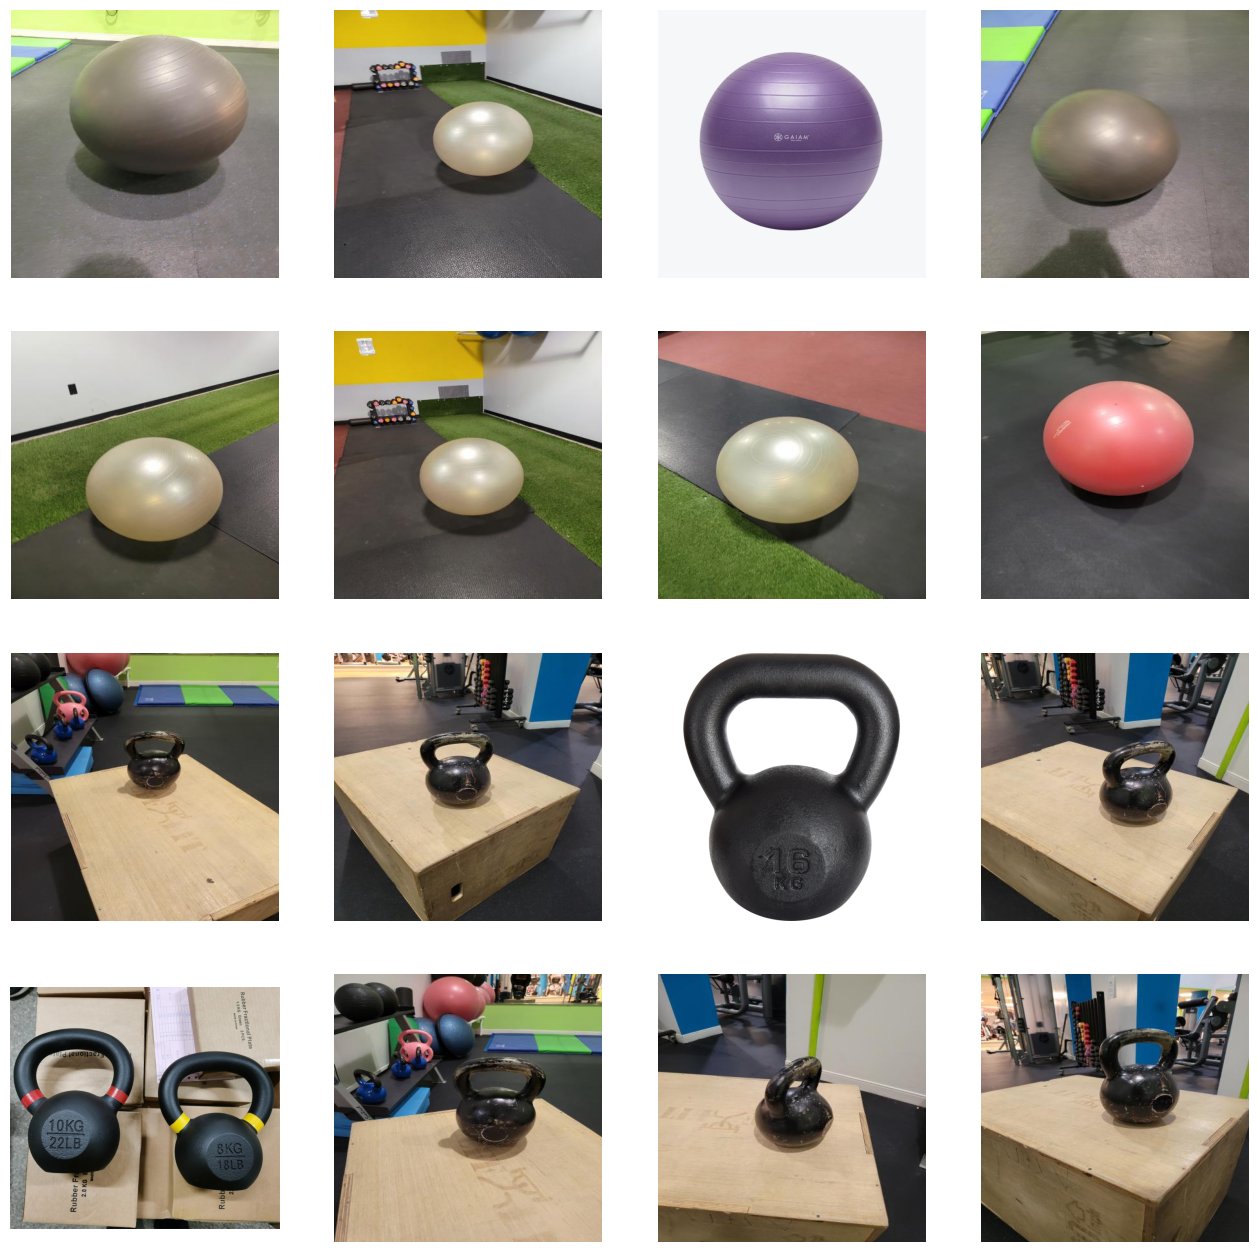

In [ ]:
# fig = plt.gcf()
# fig.set_size_inches(ncols*4, nrows*4)

# pic_index+=8

# next_exerbal_pix = [os.path.join(train_exerbal_dir, fname)
#                 for fname in train_exerbal_fnames[ pic_index-8:pic_index]
#                ]

# next_kettle_pix = [os.path.join(train_kettle_dir, fname)
#                 for fname in train_kettle_fnames[ pic_index-8:pic_index]
#                ]

# for i, img_path in enumerate(next_exerbal_pix+next_kettle_pix):
#     # Subplot indices start at 1
#     sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off')

#     img = mpimg.imread(img_path)
#     plt.imshow(img)

# plt.show()

## **Create Model**

In [ ]:
# Create the Model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 250x250 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 64)        0

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.85 and logs.get('val_acc')>0.85 and logs.get('loss')<0.3 and logs.get('val_loss')<0.3):
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## **Model Training**

In [ ]:
train_steps = float((len(os.listdir(train_bench_dir)) + len(os.listdir(train_dumbel_dir))) / batch_size)
val_steps = float((len(os.listdir(validation_bench_dir)) + len(os.listdir(validation_dumbel_dir))) / batch_size)

print('Steps per Epochs :', train_steps)
print('Validation Steps :', val_steps)

Steps per Epochs : 126.2
Validation Steps : 31.5


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=127,
    validation_steps=32,
    epochs=10,
    callbacks=[callbacks],
    verbose=1
)

Epoch 1/10


## **Model Evaluation**

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

print(f"Training Accuracy: {pd.to_numeric(acc)[-1]*100} %")
print(f"Validation Accuracy: {pd.to_numeric(val_acc)[-1]*100} %")
print(f"Training Loss: {pd.to_numeric(loss)[-1]}")
print(f"Validation Loss: {pd.to_numeric(val_loss)[-1]}")

Training Accuracy: 96.72130942344666 %
Validation Accuracy: 100.0 %
Training Loss: 0.16275501251220703
Validation Loss: 0.0368654765188694


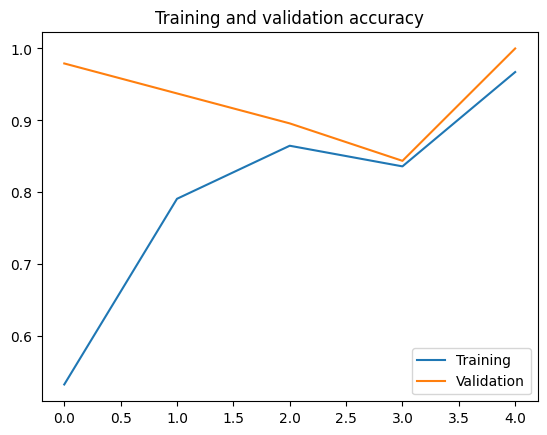

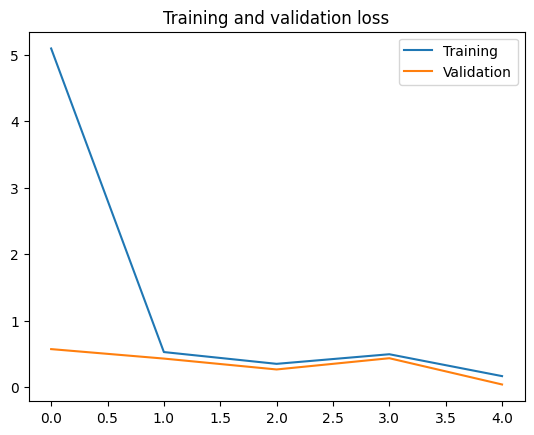

In [ ]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.title('Training and validation loss')
plt.show()

# **#3 - Lesser Images of Benchpress & Dumbells - v1**

**Total "Benchpress" images for Training :**

*   122

**Total "Dumbells" images for Training :**

*   122

**Total "Benchpress" images for Validation :**

*   48

**Total "Dumbells" images for Validation :**

*   48

## **Data Preprocessing**

### **Directory Setup**

In [ ]:
# Base Directory
base_dir = 'fitness_3/fitness_CNN_binary_3'

# Train & Validation Directory
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Train Benchpress & Dumbells Directory
train_bench_dir = os.path.join(train_dir, 'Benchpress')
train_dumbel_dir = os.path.join(train_dir, 'Dumbells')

# Validation Benchpress & Dumbells Directory
validation_bench_dir = os.path.join(validation_dir, 'Benchpress')
validation_dumbel_dir = os.path.join(validation_dir, 'Dumbells')

In [ ]:
# Show some images labels
train_bench_fnames = os.listdir(train_bench_dir)
train_dumbel_fnames = os.listdir(train_dumbel_dir)
print(train_bench_fnames[:10])
print(train_dumbel_fnames[:10])

['00000089.jpg', '00000071.jpg', '00000068.jpg', '00000047.jpg', '00000109.jpg', '00000118.jpg', '00000021.jpg', '00000004.jpg', '00000117.jpg', '00000034.jpg']
['1YVB151P6IJC.jpg', '1SJA270FZ0Z6.jpg', '1IWQ8BGLOA8T.jpg', '0KXANHMOZUC8.jpg', '0PVI5TBMH394.jpg', '2GPCRQ6DR0MF.jpg', '1BY8RR562TFM.jpg', '2BGGNFM7XV03.jpg', '1RZMTMB8XMB6.jpg', '0E8GEZH3KONK.jpg']


In [ ]:
# Total Images
print('total training Benchpress images :', len(os.listdir(train_bench_dir)))
print('total training Dumbells images :', len(os.listdir(train_dumbel_dir)))
print('total validation Benchpress images :', len(os.listdir(validation_bench_dir)))
print('total validation Dumbells images :', len(os.listdir(validation_dumbel_dir)))

total training Benchpress images : 122
total training Dumbells images : 122
total validation Benchpress images : 48
total validation Dumbells images : 48


### **Prepare Image - No Converting to TensorImage**

In [ ]:
# # All images will be rescaled by 1./255.
# train_datagen = ImageDataGenerator( rescale = 1.0/255. )
# test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# # --------------------
# # Flow training images in batches of 20 using train_datagen generator
# # --------------------
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     batch_size=20,
#                                                     class_mode='binary',
#                                                     target_size=(250, 250))
# # --------------------
# # Flow validation images in batches of 20 using test_datagen generator
# # --------------------
# validation_generator =  test_datagen.flow_from_directory(validation_dir,
#                                                          batch_size=20,
#                                                          class_mode  = 'binary',
#                                                          target_size = (250, 250))

### **Prepare Image - Convert to TensorImage**

In [ ]:
def load_images_to_tensors(bench_dir, dumbel_dir, target_size=(250, 250)):
    tensor_images = []
    labels = []  # 0 for Exercise Balls, 1 for Kettlebells

    # Function to load images from a directory and assign a label
    def load_images_from_dir(directory, label):
        for file_name in os.listdir(directory):
            file_path = os.path.join(directory, file_name)
            # Load the image
            img = image.load_img(file_path, target_size=target_size)
            # Convert the image to a numpy array and rescale
            img_array = image.img_to_array(img) / 255.0
            # Convert to tensor
            tensor_img = tf.convert_to_tensor(img_array, dtype=tf.float32)

            tensor_images.append(tensor_img)
            labels.append(label)

    # Load images from Exercise Balls directory
    load_images_from_dir(bench_dir, 0)

    # Load images from Kettlebells directory
    load_images_from_dir(dumbel_dir, 1)

    return np.array(tensor_images), np.array(labels)

In [ ]:
batch_size = 20

In [ ]:
# Load images as tensors
train_tensors, train_labels = load_images_to_tensors(train_bench_dir, train_dumbel_dir)

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, train_labels))

# Batch and shuffle the dataset
train_dataset = train_dataset.shuffle(len(train_tensors)).batch(batch_size)
# .repeat()

In [ ]:
# Load validation images as tensors
validation_tensors, validation_labels = load_images_to_tensors(validation_bench_dir, validation_dumbel_dir)

# Create TensorFlow Dataset for validation
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_tensors, validation_labels))

# Batch the dataset (adjust batch size if needed)
validation_dataset = validation_dataset.batch(batch_size)
# .repeat()

### **Show Images**

In [ ]:
# # Output: Images in a 4x4 configuration
# nrows = 4
# ncols = 4

# pic_index = 0

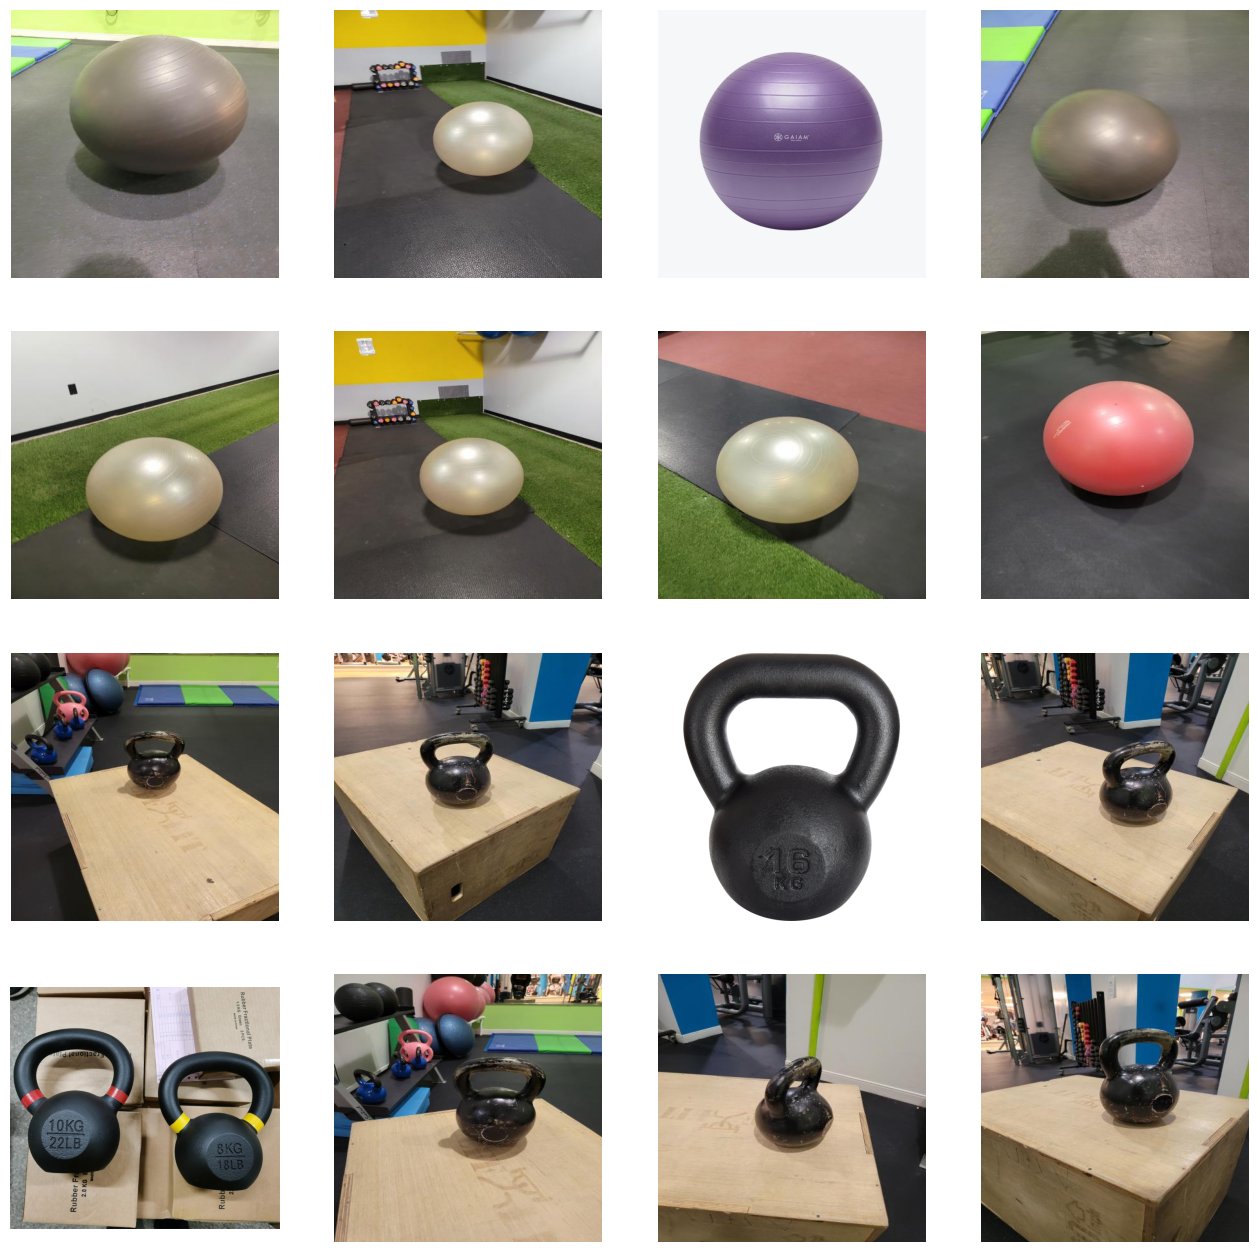

In [ ]:
# fig = plt.gcf()
# fig.set_size_inches(ncols*4, nrows*4)

# pic_index+=8

# next_exerbal_pix = [os.path.join(train_exerbal_dir, fname)
#                 for fname in train_exerbal_fnames[ pic_index-8:pic_index]
#                ]

# next_kettle_pix = [os.path.join(train_kettle_dir, fname)
#                 for fname in train_kettle_fnames[ pic_index-8:pic_index]
#                ]

# for i, img_path in enumerate(next_exerbal_pix+next_kettle_pix):
#     # Subplot indices start at 1
#     sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off')

#     img = mpimg.imread(img_path)
#     plt.imshow(img)

# plt.show()

## **Create Model**

In [ ]:
# Create the Model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 250x250 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 64)        0

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.85 and logs.get('val_acc')>0.85 and logs.get('loss')<0.3 and logs.get('val_loss')<0.3):
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## **Model Training**

In [ ]:
train_steps = float((len(os.listdir(train_bench_dir)) + len(os.listdir(train_dumbel_dir))) / batch_size)
val_steps = float((len(os.listdir(validation_bench_dir)) + len(os.listdir(validation_dumbel_dir))) / batch_size)

print('Steps per Epochs :', train_steps)
print('Validation Steps :', val_steps)

Steps per Epochs : 12.2
Validation Steps : 4.8


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=13,
    validation_steps=5,
    epochs=10,
    callbacks=[callbacks],
    verbose=1
)

Epoch 1/10
13/13 [==============================] - 15s 103ms/step - loss: 2.1314 - acc: 0.5697 - val_loss: 0.9074 - val_acc: 0.5000
Epoch 2/10
13/13 [==============================] - 1s 37ms/step - loss: 0.6877 - acc: 0.5615 - val_loss: 0.6744 - val_acc: 0.5312
Epoch 3/10
13/13 [==============================] - 1s 43ms/step - loss: 0.7235 - acc: 0.5656 - val_loss: 0.6804 - val_acc: 0.5000
Epoch 4/10
13/13 [==============================] - 1s 40ms/step - loss: 0.6968 - acc: 0.6639 - val_loss: 0.6386 - val_acc: 0.6875
Epoch 5/10
13/13 [==============================] - 1s 40ms/step - loss: 0.6027 - acc: 0.6598 - val_loss: 0.9920 - val_acc: 0.5000
Epoch 6/10
13/13 [==============================] - 1s 40ms/step - loss: 0.5798 - acc: 0.6844 - val_loss: 0.5968 - val_acc: 0.6250
Epoch 7/10
13/13 [==============================] - 1s 39ms/step - loss: 0.5594 - acc: 0.7500 - val_loss: 0.6718 - val_acc: 0.6354
Epoch 8/10
13/13 [==============================] - 0s 33ms/step - loss: 0.3688 -

## **Model Evaluation**

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

print(f"Training Accuracy: {pd.to_numeric(acc)[-1]*100} %")
print(f"Validation Accuracy: {pd.to_numeric(val_acc)[-1]*100} %")
print(f"Training Loss: {pd.to_numeric(loss)[-1]}")
print(f"Validation Loss: {pd.to_numeric(val_loss)[-1]}")

Training Accuracy: 96.72130942344666 %
Validation Accuracy: 100.0 %
Training Loss: 0.16275501251220703
Validation Loss: 0.0368654765188694


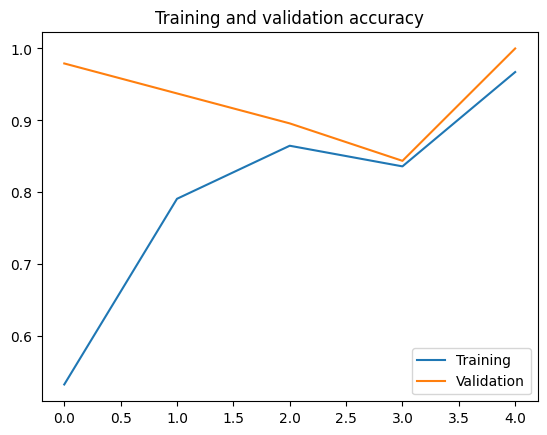

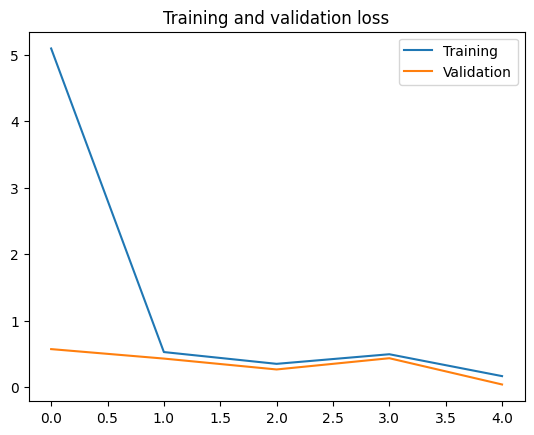

In [ ]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.title('Training and validation loss')
plt.show()

# **#4 - Lesser Images of Benchpress & Dumbells - v2**

**Total "Benchpress" images for Training :**

*   500


**Total "Dumbells" images for Training :**

*   1000

**Total "Benchpress" images for Validation :**

*   130

**Total "Dumbells" images for Validation :**

*   500

## **Data Preprocessing**

### **Directory Setup**

In [ ]:
# Base Directory
base_dir = 'fitness_4/fitness_CNN_binary_4'

# Train & Validation Directory
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Train Benchpress & Dumbells Directory
train_bench_dir = os.path.join(train_dir, 'Benchpress')
train_dumbel_dir = os.path.join(train_dir, 'Dumbells')

# Validation Benchpress & Dumbells Directory
validation_bench_dir = os.path.join(validation_dir, 'Benchpress')
validation_dumbel_dir = os.path.join(validation_dir, 'Dumbells')

In [ ]:
# Show some images labels
train_bench_fnames = os.listdir(train_bench_dir)
train_dumbel_fnames = os.listdir(train_dumbel_dir)
print(train_bench_fnames[:10])
print(train_dumbel_fnames[:10])

['00000198.jpg', '00000397.jpg', '00000425.jpg', '00000268.jpg', '00000348.jpg', '00000358.jpg', '00000278.jpg', '00000121.jpg', '00000235.jpg', '00000294.jpg']
['1015822-Bowflex-Adjustable-Dumbbells-Pros-Cons-Cost-and-More-732x549-thumbnail.jpg', 'AVWI8PUFVH99.jpg', 'image17.jpeg', 'EBRIS9PGXYFD.jpg', 'BXB0FB5M8EE5.jpg', 'OJIM5ZY7GOOS.jpg', 'PQFB814VP50E.jpg', 'P8I7MOJNUJ0Z.jpg', 'EEDBIQ5T1QGS.jpg', 'BJFZLO2P842A.jpg']


In [ ]:
# Total Images
print('total training Benchpress images :', len(os.listdir(train_bench_dir)))
print('total training Dumbells images :', len(os.listdir(train_dumbel_dir)))
print('total validation Benchpress images :', len(os.listdir(validation_bench_dir)))
print('total validation Dumbells images :', len(os.listdir(validation_dumbel_dir)))

total training Benchpress images : 500
total training Dumbells images : 1000
total validation Benchpress images : 130
total validation Dumbells images : 500


### **Prepare Image - No Converting to TensorImage**

In [ ]:
# # All images will be rescaled by 1./255.
# train_datagen = ImageDataGenerator( rescale = 1.0/255. )
# test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# # --------------------
# # Flow training images in batches of 20 using train_datagen generator
# # --------------------
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     batch_size=20,
#                                                     class_mode='binary',
#                                                     target_size=(200, 200))
# # --------------------
# # Flow validation images in batches of 20 using test_datagen generator
# # --------------------
# validation_generator =  test_datagen.flow_from_directory(validation_dir,
#                                                          batch_size=20,
#                                                          class_mode  = 'binary',
#                                                          target_size = (200, 200))

### **Prepare Image - Convert to TensorImage**

In [ ]:
def load_images_to_tensors(bench_dir, dumbel_dir, target_size=(200, 200)):
    tensor_images = []
    labels = []  # 0 for Exercise Balls, 1 for Kettlebells

    # Function to load images from a directory and assign a label
    def load_images_from_dir(directory, label):
        for file_name in os.listdir(directory):
            file_path = os.path.join(directory, file_name)
            # Load the image
            img = image.load_img(file_path, target_size=target_size)
            # Convert the image to a numpy array and rescale
            img_array = image.img_to_array(img) / 255.0
            # Convert to tensor
            tensor_img = tf.convert_to_tensor(img_array, dtype=tf.int32)

            tensor_images.append(tensor_img)
            labels.append(label)

    # Load images from Exercise Balls directory
    load_images_from_dir(bench_dir, 0)

    # Load images from Kettlebells directory
    load_images_from_dir(dumbel_dir, 1)

    return np.array(tensor_images), np.array(labels)

In [ ]:
batch_size = 32

In [ ]:
# Load images as tensors
train_tensors, train_labels = load_images_to_tensors(train_bench_dir, train_dumbel_dir)

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, train_labels))

# Batch and shuffle the dataset
train_dataset = train_dataset.shuffle(len(train_tensors)).batch(batch_size)
# .repeat()

In [ ]:
# Load validation images as tensors
validation_tensors, validation_labels = load_images_to_tensors(validation_bench_dir, validation_dumbel_dir)

# Create TensorFlow Dataset for validation
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_tensors, validation_labels))

# Batch the dataset (adjust batch size if needed)
validation_dataset = validation_dataset.batch(batch_size)
# .repeat()

### **Show Images**

In [ ]:
# # Output: Images in a 4x4 configuration
# nrows = 4
# ncols = 4

# pic_index = 0

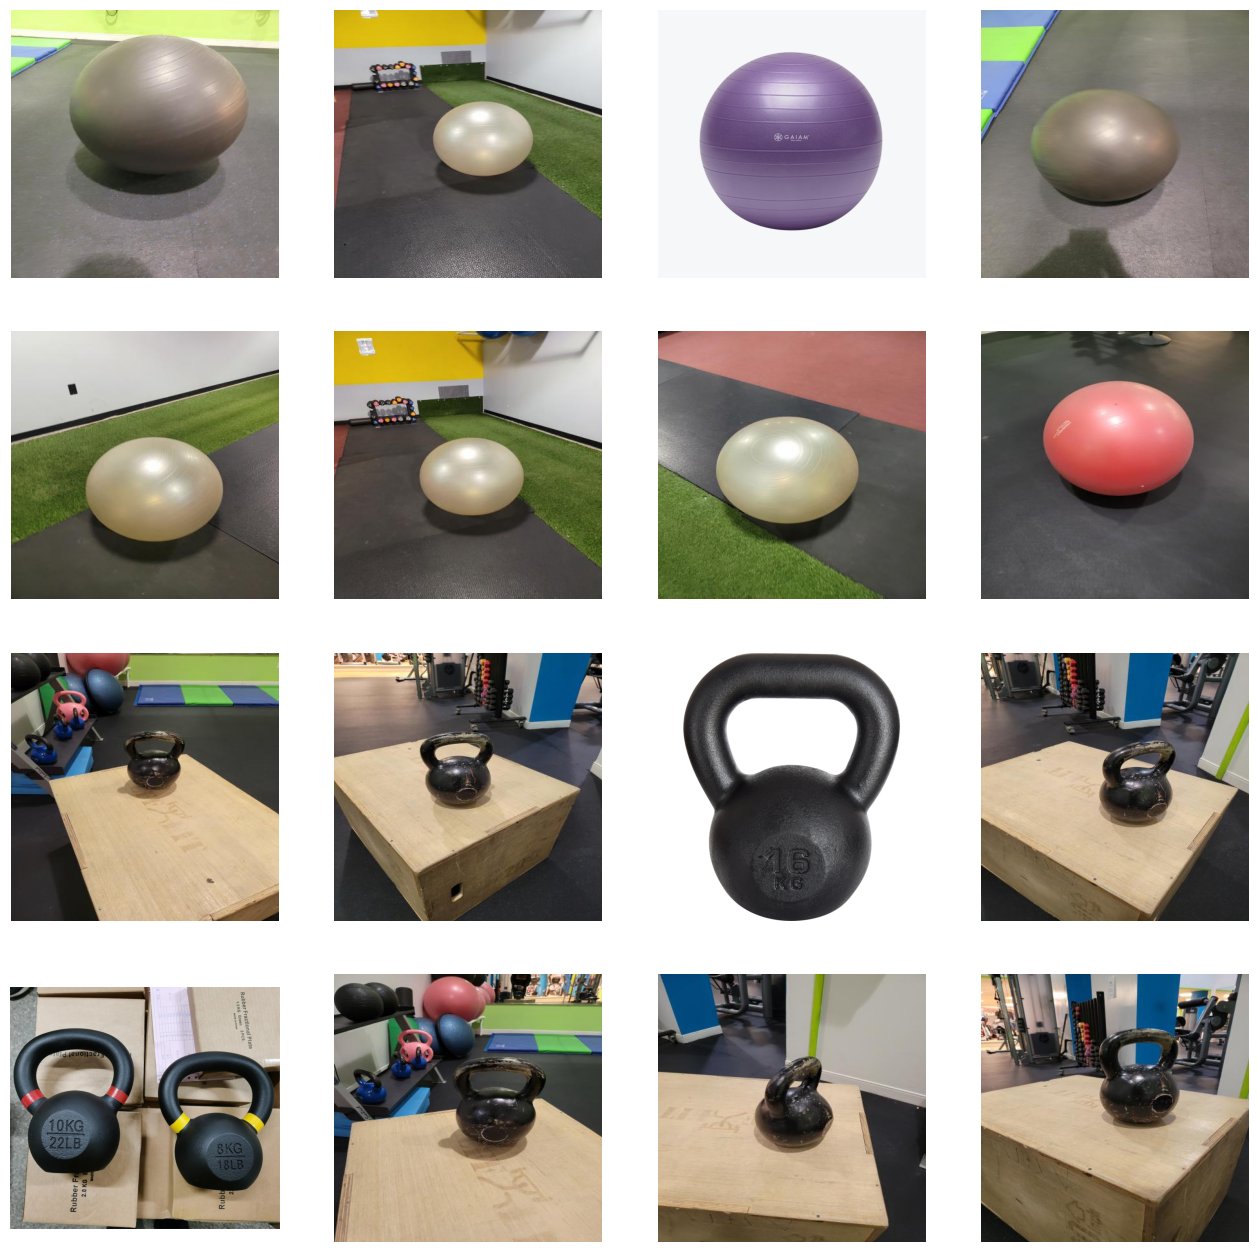

In [ ]:
# fig = plt.gcf()
# fig.set_size_inches(ncols*4, nrows*4)

# pic_index+=8

# next_exerbal_pix = [os.path.join(train_exerbal_dir, fname)
#                 for fname in train_exerbal_fnames[ pic_index-8:pic_index]
#                ]

# next_kettle_pix = [os.path.join(train_kettle_dir, fname)
#                 for fname in train_kettle_fnames[ pic_index-8:pic_index]
#                ]

# for i, img_path in enumerate(next_exerbal_pix+next_kettle_pix):
#     # Subplot indices start at 1
#     sp = plt.subplot(nrows, ncols, i + 1)
#     sp.axis('Off')

#     img = mpimg.imread(img_path)
#     plt.imshow(img)

# plt.show()

## **Create Model**

In [ ]:
# Create the Model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x200 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 64)        0

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.85 and logs.get('val_acc')>0.85 and logs.get('loss')<0.3 and logs.get('val_loss')<0.3):
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## **Model Training**

In [ ]:
train_steps = float((len(os.listdir(train_bench_dir)) + len(os.listdir(train_dumbel_dir))) / batch_size)
val_steps = float((len(os.listdir(validation_bench_dir)) + len(os.listdir(validation_dumbel_dir))) / batch_size)

print('Steps per Epochs :', train_steps)
print('Validation Steps :', val_steps)

Steps per Epochs : 46.875
Validation Steps : 19.6875


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=47,
    validation_steps=20,
    epochs=10,
    callbacks=[callbacks],
    verbose=1
)

Epoch 1/10
47/47 [==============================] - 14s 48ms/step - loss: 0.7072 - acc: 0.6907 - val_loss: 0.5608 - val_acc: 0.7603
Epoch 2/10
47/47 [==============================] - 2s 35ms/step - loss: 0.4968 - acc: 0.7547 - val_loss: 0.3666 - val_acc: 0.8460
Epoch 3/10
47/47 [==============================] - 2s 32ms/step - loss: 0.4147 - acc: 0.8167 - val_loss: 0.3899 - val_acc: 0.8238
Epoch 4/10
47/47 [==============================] - 2s 32ms/step - loss: 0.3113 - acc: 0.8760 - val_loss: 0.3502 - val_acc: 0.8651
Epoch 5/10
47/47 [==============================] - 2s 36ms/step - loss: 0.2290 - acc: 0.9227 - val_loss: 0.4623 - val_acc: 0.8222
Epoch 6/10
47/47 [==============================] - 2s 34ms/step - loss: 0.1277 - acc: 0.9580 - val_loss: 0.4615 - val_acc: 0.8492
Epoch 7/10
47/47 [==============================] - 2s 32ms/step - loss: 0.0559 - acc: 0.9840 - val_loss: 0.6987 - val_acc: 0.8159
Epoch 8/10
47/47 [==============================] - 2s 33ms/step - loss: 0.0250 - 

## **Model Evaluation**

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

print(f"Training Accuracy: {pd.to_numeric(acc)[-1]*100} %")
print(f"Validation Accuracy: {pd.to_numeric(val_acc)[-1]*100} %")
print(f"Training Loss: {pd.to_numeric(loss)[-1]}")
print(f"Validation Loss: {pd.to_numeric(val_loss)[-1]}")

Training Accuracy: 96.72130942344666 %
Validation Accuracy: 100.0 %
Training Loss: 0.16275501251220703
Validation Loss: 0.0368654765188694


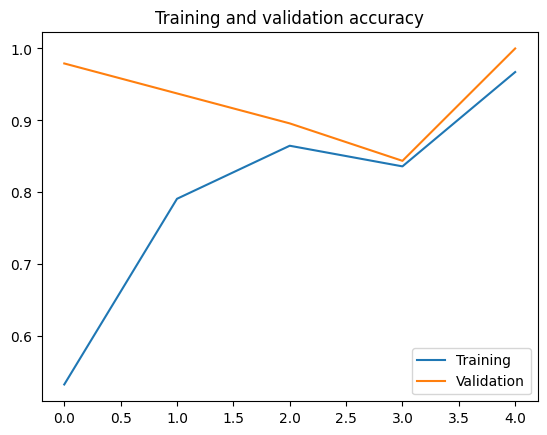

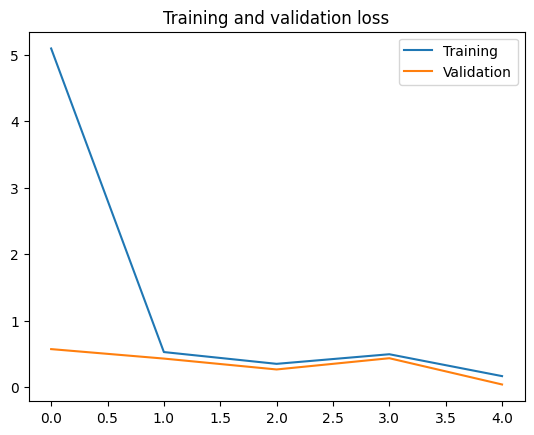

In [ ]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.legend()
plt.title('Training and validation loss')
plt.show()

# **Save & Deploy Model**

## **Save & Deploy Model (in .tflite)**

In [ ]:
export_dir = 'saved_model/1'

tf.saved_model.save(model,export_dir=export_dir)

In [ ]:
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [optimization]

# Generate the TFLite model
tflite_model = converter.convert();

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

17368920

## **Save & Deploy Model (in .h5 and .json)**

In [ ]:
# Save Model
saved_model_path = "./model.h5"

model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Convert Model to JSON format
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-12-05 17:18:04.994384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 17:18:04.994494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 17:18:04.997746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 17:18:06.622088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# ZIP the Model
!zip model.zip *.bin model.json

  adding: group1-shard100of191.bin (deflated 8%)
  adding: group1-shard101of191.bin (deflated 8%)
  adding: group1-shard102of191.bin (deflated 8%)
  adding: group1-shard103of191.bin (deflated 8%)
  adding: group1-shard104of191.bin (deflated 8%)
  adding: group1-shard105of191.bin (deflated 8%)
  adding: group1-shard106of191.bin (deflated 8%)
  adding: group1-shard107of191.bin (deflated 8%)
  adding: group1-shard108of191.bin (deflated 8%)
  adding: group1-shard109of191.bin (deflated 8%)
  adding: group1-shard10of191.bin (deflated 8%)
  adding: group1-shard110of191.bin (deflated 8%)
  adding: group1-shard111of191.bin (deflated 8%)
  adding: group1-shard112of191.bin (deflated 8%)
  adding: group1-shard113of191.bin (deflated 8%)
  adding: group1-shard114of191.bin (deflated 8%)
  adding: group1-shard115of191.bin (deflated 8%)
  adding: group1-shard116of191.bin (deflated 8%)
  adding: group1-shard117of191.bin (deflated 8%)
  adding: group1-shard118of191.bin (deflated 8%)
  adding: group1-shar

# **Testing Prediction**

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([  1, 200, 200,   3], dtype=int32),
  'shape_signature': array([ -1, 200, 200,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 21,
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path):
  target_size = (200, 200)
  img = Image.open(image_path)
  img = img.resize(target_size)
  img_array = np.array(img) / 255.0
  img_array = img_array.astype(np.float32)
  img_array = np.expand_dims(img_array, axis=0)
  return img_array

In [ ]:
# # Load and preprocess the Benchpress Image
# img_bench = '00000000.jpg'  # Replace with your image path
# preprocessed_image = preprocess_image(img_bench)

# # Load and preprocess the Dumbell Image
# img_dumbel = '00QZN3CAUH5A.jpg'  # Replace with your image path
# preprocessed_image = preprocess_image(img_dumbel)

# Load and Preprocess Image
img_test = 'bench2.jpg'
preprocessed_image = preprocess_image(img_test)

In [ ]:
# Set the tensor to point to the input data to be inferred
interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

# Run the interpreter
interpreter.invoke()

# Extract the output
output_data = interpreter.get_tensor(output_details[0]['index'])

# Interpret the output
prediction = output_data[0][0]
predicted_class = 'Dumbells' if prediction > 0.5 else 'Benchpress'
print(f"Predicted Class: {predicted_class}, Probability: {prediction}")

Predicted Class: Benchpress, Probability: 0.0010445406660437584


---

# **Experiment #2**

---

# **#5 - Lesser Images of Benchpress & Dumbells - v3**

**Total "Benchpress" images for Training :**

*   500


**Total "Dumbells" images for Training :**

*   1000

**Total "Benchpress" images for Validation :**

*   130

**Total "Dumbells" images for Validation :**

*   500

## **Import Libraries**

In [ ]:
# Import Libraries
import matplotlib.pyplot as plt
import shutil
import numpy as np
import pandas as pd
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## **Data (Images) Preprocessing**

In [ ]:
# Set Params
batch_size = 32
img_height = 200
img_width = 200

# Base Directory
base_dir = 'fitness_5/fitness_CNN_binary_5'

In [ ]:
# Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2130 files belonging to 2 classes.
Using 1704 files for training.


In [ ]:
# Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2130 files belonging to 2 classes.
Using 426 files for validation.


In [ ]:
# Class Names
class_names = train_ds.class_names
print(class_names)

['Benchpress', 'Dumbells']


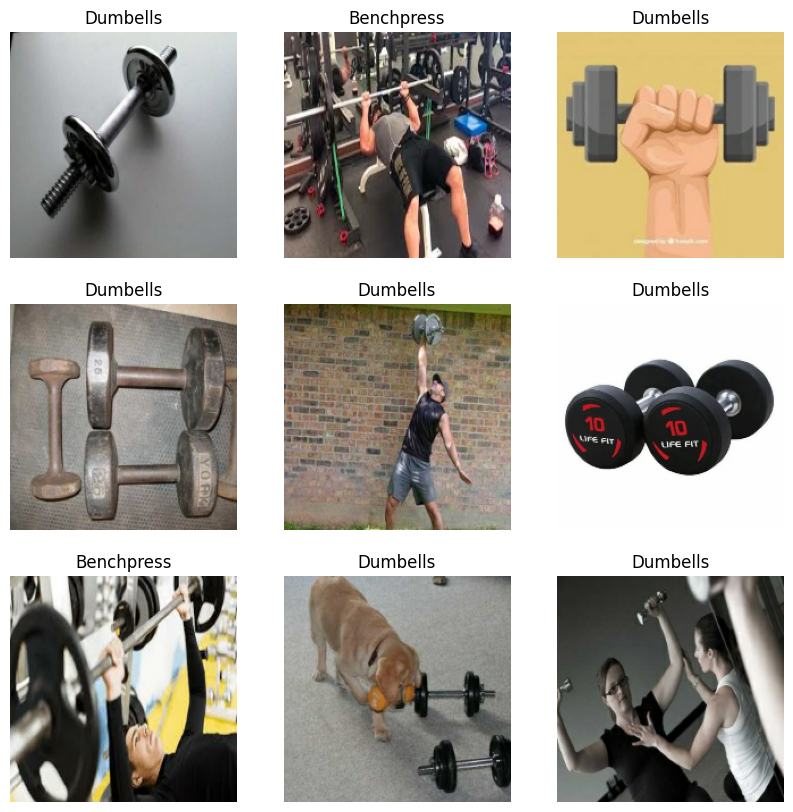

In [ ]:
# Visualize Images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Images Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        ]
    )

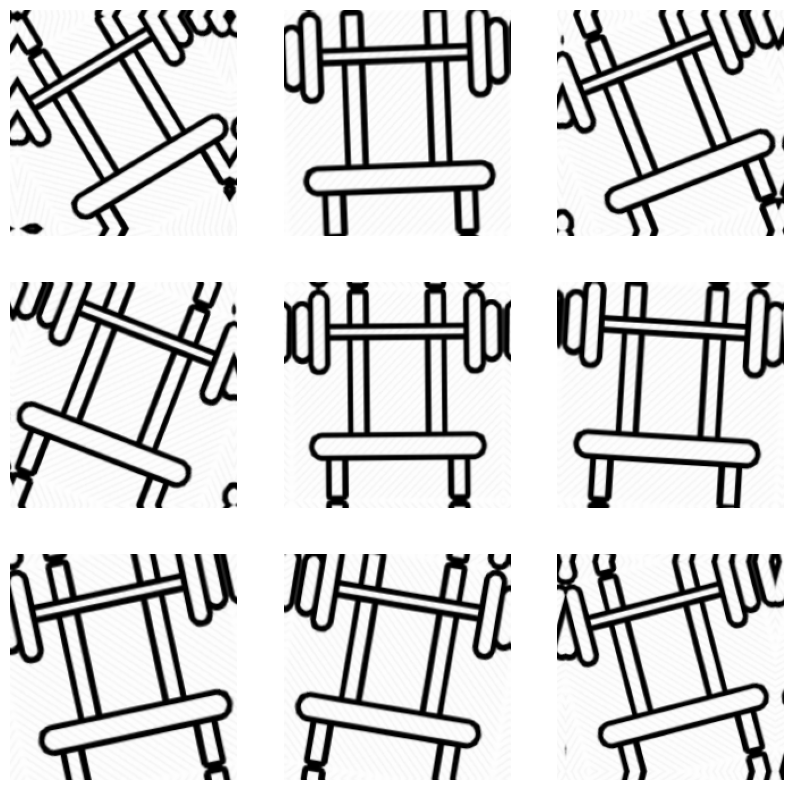

In [ ]:
# Visualize Augmented Images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = len(class_names)
print(num_classes)

2


## **Model Preparation**

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
    ])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                 

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85 and logs.get('loss')<0.3 and logs.get('val_loss')<0.3):
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## **Model Training**

In [ ]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callbacks]
    )

## **Model Evaluation**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

print(f"Training Accuracy: {pd.to_numeric(acc)[-1]*100} %")
print(f"Validation Accuracy: {pd.to_numeric(val_acc)[-1]*100} %")
print(f"Training Loss: {pd.to_numeric(loss)[-1]}")
print(f"Validation Loss: {pd.to_numeric(val_loss)[-1]}")

Training Accuracy: 87.67605423927307 %
Validation Accuracy: 80.98591566085815 %
Training Loss: 0.2875906825065613
Validation Loss: 0.37119099497795105


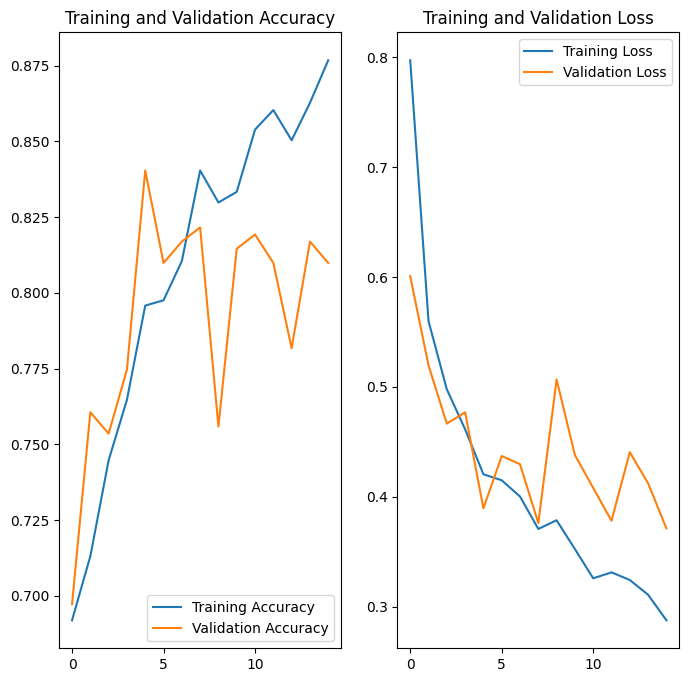

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Prediction Test**

In [ ]:
img = tf.keras.utils.load_img(
    "bench2.jpg", target_size=(img_height, img_width)
    )

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 [==============================] - 0s 136ms/step
This image most likely belongs to Benchpress with a 99.97 percent confidence.


## **Save & Deploy Model (in .tflite)**

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

## **Prediction Test with The Deployed Model**

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_input'], 'outputs': ['outputs']}}

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
    )

This image most likely belongs to Benchpress with a 99.97 percent confidence.


---

# **END**

---